In [6]:
!nvidia-smi

Mon Jul 28 08:02:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P0             29W /   70W |     103MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Libraries

In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, mixed_precision


2025-07-28 19:35:26.870121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753731327.256504      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753731327.364191      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# import tensorflow as tf
print(tf.__version__)
# Check if a GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to prevent TensorFlow from allocating all memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and will be used.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error: {e}")
else:
    print("GPU is not available, running on CPU.")

tf.test.is_gpu_available()

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("Mixed precision enabled:", policy)

2.18.0
GPU is available and will be used.
Mixed precision enabled: <DTypePolicy "mixed_float16">


I0000 00:00:1753731346.467482      36 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753731346.468209      36 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Imports

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 3
FROZEN_EPOCHS = 2

train_csv_path = "/kaggle/input/diabetic-retinopathy-detection/trainLabels.csv.zip"
train_images_dir = "/kaggle/input/diabetic-retinopathy-train-unzipped/train/"
test_images_dir = "/kaggle/input/diabetic-retinopathy-test-unzipped/test/"
submission_csv_path = "/kaggle/input/diabetic-retinopathy-detection/sampleSubmission.csv.zip"

In [4]:
img_number = 10016

df = pd.read_csv(train_csv_path)
df_train = df[:img_number].copy()
df_train.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


**Train Test Split**

In [6]:
# Convert multiclass level to binary: 0 = No DR, 1 = DR Present
df_train["Label"] = df_train["level"].apply(lambda x: False if x == 0 else True)

df_train["filepath"] = df_train["image"].apply(lambda x: os.path.join(train_images_dir, f"{x}.jpeg"))

train_df, val_df = train_test_split(df_train, test_size=0.4, stratify=df_train["Label"], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df["Label"], random_state=42)


In [7]:
print(train_df.shape, val_df.shape, test_df.shape)
# train_df.filepath[0]
train_df

(6009, 4) (2003, 4) (2004, 4)


,image,level,Label,filepath
5408,6808_left,1,True,/kaggle/input/diabetic-retinopathy-train-unzip...
5319,6691_right,1,True,/kaggle/input/diabetic-retinopathy-train-unzip...
401,457_right,0,False,/kaggle/input/diabetic-retinopathy-train-unzip...
7344,9226_left,0,False,/kaggle/input/diabetic-retinopathy-train-unzip...
7246,9100_left,1,True,/kaggle/input/diabetic-retinopathy-train-unzip...
...,...,...,...,...
2538,3149_left,0,False,/kaggle/input/diabetic-retinopathy-train-unzip...
536,650_left,0,False,/kaggle/input/diabetic-retinopathy-train-unzip...
6960,8749_left,3,True,/kaggle/input/diabetic-retinopathy-train-unzip...
3379,4212_right,0,False,/kaggle/input/diabetic-retinopathy-train-unzip...


# Visualization

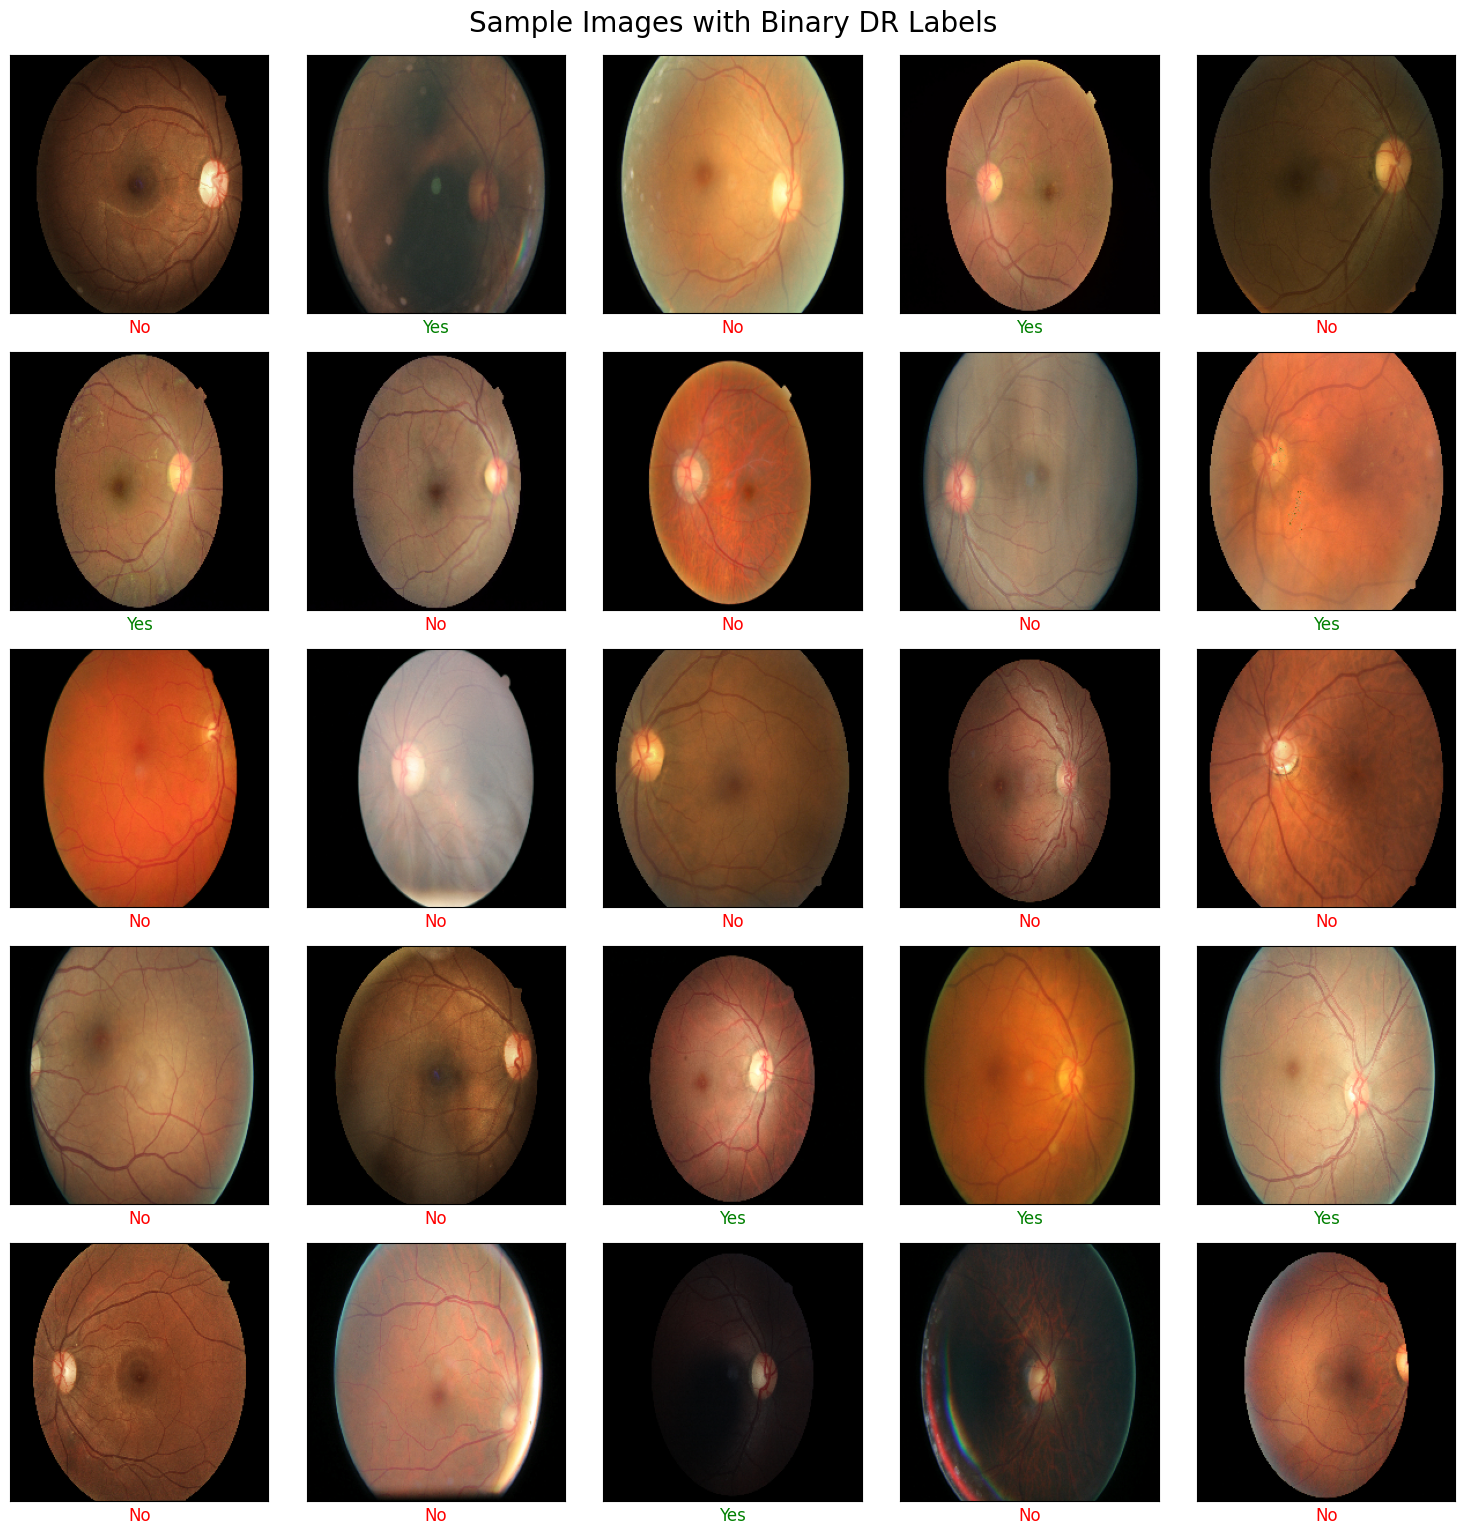

In [10]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

# Show first 25 images from train_df
for idx, (i, row) in enumerate(train_df.head(25).iterrows()):
    plt.subplot(5, 5, idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Load and preprocess image
    img_path = row['filepath']
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Warning: Image not found at {img_path}")
        continue
    
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Set label from binary column
    label = row.get('binary_label', row.get('Label', None))
    label_text = 'Yes' if label else 'No'
    
    plt.imshow(img)
    plt.xlabel(label_text, fontsize=12, color='green' if label else 'red')

plt.tight_layout()
plt.suptitle("Sample Images with Binary DR Labels", fontsize=20, y=1.02)
plt.show()


# Evaluation Functions

## Results

In [10]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, cohen_kappa_score,
    precision_recall_curve, roc_curve
)
import tensorflow as tf
import pandas as pd
import numpy as np
import os

def Results(model, test_set, save_csv=False):
    # Evaluate the model
    results = model.evaluate(test_set)
    print("Evaluation results: ", results)

    y_true = []
    y_pred_probs = []

    print("Loading....", flush=True)

    for images, labels in test_set:
        y_true.extend(labels.numpy())
        y_pred_probs.extend(model.predict(images, verbose=0).flatten())

    y_true = tf.convert_to_tensor(y_true)
    y_pred_probs = tf.convert_to_tensor(y_pred_probs)
    y_pred = (y_pred_probs > 0.5).numpy().astype("int32")

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    prc_auc = average_precision_score(y_true, y_pred_probs)
    conf_matrix = confusion_matrix(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    npv = tn / (tn + fn)

    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print(f"PRC AUC: {prc_auc}")
    print(f"Confusion Matrix: \n{conf_matrix}")
    print(f"Kappa Coefficient: {kappa}")
    print(f"NPV: {npv}")

    if save_csv:
        # Compute ROC and Precision-Recall curves
        fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
        prec, rec, _ = precision_recall_curve(y_true, y_pred_probs)

        # Prepare DataFrame
        max_len = max(len(fpr), len(prec))
        fpr = np.pad(fpr, (0, max_len - len(fpr)), 'constant', constant_values=np.nan)
        tpr = np.pad(tpr, (0, max_len - len(tpr)), 'constant', constant_values=np.nan)
        prec = np.pad(prec, (0, max_len - len(prec)), 'constant', constant_values=np.nan)
        rec = np.pad(rec, (0, max_len - len(rec)), 'constant', constant_values=np.nan)

        df = pd.DataFrame({
            'FPR': fpr,
            'TPR': tpr,
            'Precision': prec,
            'Recall': rec
        })


        file_name = f"{model_name}_metrics.csv"
        df.to_csv(file_name, index=False)
        print(f"Saved metrics to: {file_name}")


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, cohen_kappa_score
import tensorflow as tf

def Results_old(model, test_set):
    # Evaluate the model
    results = model.evaluate(test_set)
    print("Evaluation results: ", results)

    y_true = []
    y_pred_probs = []

    print("Loading....", flush=True)

    for images, labels in test_set:
        y_true.extend(labels.numpy())
        y_pred_probs.extend(model.predict(images, verbose=0).flatten())

    y_true = tf.convert_to_tensor(y_true)
    y_pred_probs = tf.convert_to_tensor(y_pred_probs)
    y_pred = (y_pred_probs > 0.5).numpy().astype("int32")

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    prc_auc = average_precision_score(y_true, y_pred_probs)
    conf_matrix = confusion_matrix(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    npv = tn / (tn + fn)

    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print(f"PRC AUC: {prc_auc}")
    print(f"Confusion Matrix: \n{conf_matrix}")
    print(f"Kappa Coefficient: {kappa}")
    print(f"NPV: {npv}")

## MACS & FLOPS

In [12]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model, input_shape):
    # Convert Keras model to ConcreteFunction
    concrete_func = tf.function(model).get_concrete_function(tf.TensorSpec(input_shape, tf.float32))
    
    # Convert ConcreteFunction to a frozen graph
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    
    # Create a session to run the frozen graph
    with tf.compat.v1.Session(graph=tf.Graph()) as sess:
        tf.import_graph_def(graph_def, name="")
        graph = tf.compat.v1.get_default_graph()
        
        # Calculate FLOPs using TensorFlow profiler
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        
    return flops.total_float_ops

In [ ]:
# Define input shape
input_shape = (1, 224, 224,3 )
# Calculate FLOPs
flops = get_flops(model, input_shape)
macs = flops // 2  # MACs is half the FLOPs for Conv2D

print(f"MACs: {macs}")
print(f"FLOPs: {flops}")

## Parameters

In [ ]:
import numpy as np

def model_parametersInfo(model):
    """
    Prints total, trainable, and non-trainable parameters of a Keras model.
    """
    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_variables])

    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {non_trainable_params:,}")


## Inference Report

In [13]:
import tensorflow as tf
import psutil
import os
import time

def inference_Report(model, test_set):
    process = psutil.Process(os.getpid())

    if tf.config.list_physical_devices('GPU'):
        gpu_enabled = True
        gpu_device = 'GPU:0'
    else:
        gpu_enabled = False

    print("🔍 Capturing memory stats and inference time for 100 images...\n")

    # --- Before Inference ---
    ram_before = process.memory_info().rss
    gpu_before = tf.config.experimental.get_memory_info(gpu_device)['current'] if gpu_enabled else 0

    total_images = 0
    start_time = time.time()

    for images, _ in test_set:
        for i in range(images.shape[0]):
            if total_images >= 100:
                break
            image = tf.expand_dims(images[i], axis=0)
            _ = model(image, training=False)
            total_images += 1
        if total_images >= 100:
            break

    end_time = time.time()

    # --- After Inference ---
    ram_after = process.memory_info().rss
    gpu_after = tf.config.experimental.get_memory_info(gpu_device)['current'] if gpu_enabled else 0

    # --- Results ---
    print("📊 Inference Resource Usage Summary (100 images):")
    print(f"CPU RAM Before: {ram_before / (1024 ** 2):.2f} MB")
    print(f"CPU RAM After : {ram_after / (1024 ** 2):.2f} MB")
    print(f"CPU RAM Used  : {(ram_after - ram_before) / (1024 ** 2):.2f} MB\n")

    if gpu_enabled:
        print(f"GPU Mem Before: {gpu_before / (1024 ** 2):.2f} MB")
        print(f"GPU Mem After : {gpu_after / (1024 ** 2):.2f} MB")
        print(f"GPU Mem Used  : {(gpu_after - gpu_before) / (1024 ** 2):.2f} MB\n")
    else:
        print("GPU Not Detected.\n")
    time_per_img = (end_time - start_time)/100
    print(f"🕒 Inference Time per image: {time_per_img:.4f} seconds")



# Data Pipeline

In [14]:
def retreive_dataset(set_name):
    images,labels=[],[]
    def imgResize(img,width,height):
        imgResize = cv2.resize(img,(width,height))
        return imgResize
    
    for (img, imclass) in zip(set_name['filepath'], set_name['Label']):
        img = cv2.imread(img)

        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   #BGR to RGB
        img = cv2.resize(img, (224, 224))    
        # img = img.astype(np.float32) / 255.0   #preprocess
        images.append(img)
        if(imclass==True):
            labels.append(1)
        else:
            labels.append(0)
    print(f"Done")
    return np.array(images),np.array(labels)

In [15]:
X_train,y_train=retreive_dataset(train_df)
X_val,y_val=retreive_dataset(val_df)
X_test,y_test=retreive_dataset(test_df)

Done
Done
Done


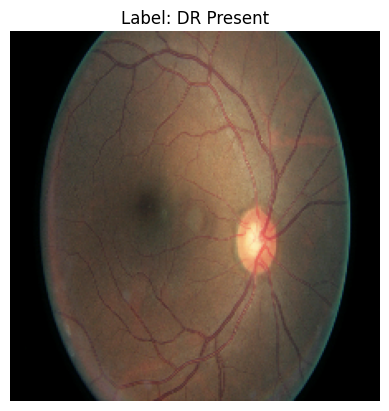

In [18]:
def show_images(images, labels, class_names={0: 'No DR', 1: 'DR Present'}, n=25):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(class_names.get(labels[i], str(labels[i])))
        plt.axis('off')
    plt.suptitle("Sample Images", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()


index = 0  # Change this to view another image
image = X_train[index]
label = y_train[index]

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Label: {'DR Present' if label == 1 else 'No DR'}")
plt.axis('off')
plt.show()

In [16]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

I0000 00:00:1753732068.391917      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753732068.392190      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Xception

In [17]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

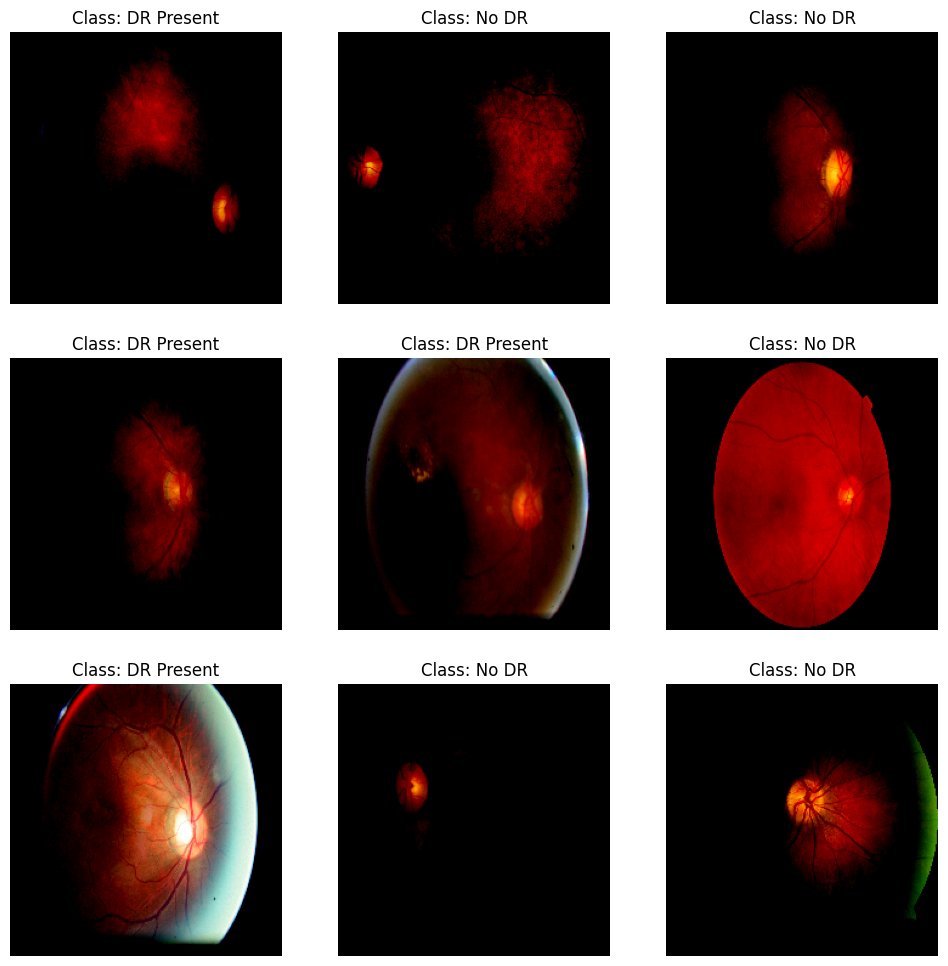

In [21]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        img = (X_batch[index].numpy())
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img /np.max(img)) # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt= 'DR Present'
        else:
            classt= "No DR"
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [23]:
tf.random.set_seed(42)  # Ensures reproducibility

tf.keras.backend.clear_session()
# Ensures reproducibility


base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [25]:
# Define input shape
input_shape = (1, 224, 224,3 )
# Calculate FLOPs
flops = get_flops(model, input_shape)
macs = flops // 2  # MACs is half the FLOPs for Conv2D

print(f"MACs: {macs}")
print(f"FLOPs: {flops}")

I0000 00:00:1753732361.606437      36 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1753732361.606605      36 single_machine.cc:361] Starting new session
I0000 00:00:1753732361.608992      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753732361.609214      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1753732364.693135      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753732364.693410      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 M


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

model_name = "DR_Xception"

# checkpoint_callback = ModelCheckpoint(
#     filepath='best_model.keras',  # Path to save the model
#     monitor='val_accuracy',        # yMetric to monitor
#     save_best_only=True,       # Save only the best model
#     save_weights_only=False,   # Save the entire model, not just weights
#     mode='max',                # Mode to minimize the monitored metric
#     verbose=1                  # Verbosity mode
# )
csv_logger = CSVLogger(model_name+'.csv',append = True)

# callbacks = [checkpoint_callback,csv_logger]
callbacks = [csv_logger]

In [27]:
history = model.fit(train_set, validation_data=valid_set, epochs=10, callbacks= callbacks)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - accuracy: 0.6632 - loss: 0.6307 - val_accuracy: 0.7259 - val_loss: 0.5910
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 189ms/step - accuracy: 0.7164 - loss: 0.5945 - val_accuracy: 0.7259 - val_loss: 0.5796
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.7217 - loss: 0.5807 - val_accuracy: 0.7274 - val_loss: 0.5737
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - accuracy: 0.7282 - loss: 0.5690 - val_accuracy: 0.7274 - val_loss: 0.5669
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 195ms/step - accuracy: 0.7166 - loss: 0.5736 - val_accuracy: 0.7329 - val_loss: 0.5620
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 193ms/step - accuracy: 0.7208 - loss: 0.5701 - val_accuracy: 0.7359 - val_loss: 0.5589
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.7229 - loss: 0.5676 - val_accuracy: 0.7404 - val_loss: 0.5563
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 194ms/step - accuracy: 0.7269 - loss: 0

In [28]:
model.save_weights(model_name+'.weights.h5')

# model.load_weights('/kaggle/working/DR_Xception.weights.h5')

In [29]:
Results(model,test_set,save_csv=True)

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - accuracy: 0.7411 - loss: 0.5487
Evaluation results:  [0.5619980692863464, 0.7300398945808411]
Loading....
Accuracy: 0.7300399201596807
Precision: 0.5818181818181818
Recall: 0.05818181818181818
F1 Score: 0.10578512396694215
ROC AUC: 0.6410253845191947
PRC AUC: 0.4164733289719039
Confusion Matrix: 
[[1431   23]
 [ 518   32]]
Kappa Coefficient: 0.05882005694839931
NPV: 0.7342226782965623
Saved metrics to: DR_Xception_metrics.csv


In [32]:
inference_Report(model,test_set)

🔍 Capturing memory stats and inference time for 100 images...

📊 Inference Resource Usage Summary (100 images):
CPU RAM Before: 8969.44 MB
CPU RAM After : 8976.69 MB
CPU RAM Used  : 7.25 MB

GPU Mem Before: 1610.02 MB
GPU Mem After : 1628.39 MB
GPU Mem Used  : 18.38 MB

🕒 Inference Time per image: 0.1326 seconds


# Xception fine tuned

In [42]:
n =len(base_model.layers)
L = int(0.3*n)  # 30% of n
f"{L} trainable of {n} layers"

'39 trainable of 132 layers'

In [43]:
for layer in base_model.layers[-L:]:
    layer.trainable = True

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

csv_logger = CSVLogger(model_name+'_ft.csv',append = True)

callbacks = [csv_logger]

In [46]:
history = model.fit(train_set, validation_data=valid_set, epochs=10, callbacks= callbacks)


Epoch 1/10


E0000 00:00:1753733762.018462     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753733762.159137     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7257 - loss: 0.5727

E0000 00:00:1753733815.131899     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753733815.270184     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


188/188 ━━━━━━━━━━━━━━━━━━━━ 92s 355ms/step - accuracy: 0.7259 - loss: 0.5725 - val_accuracy: 0.7723 - val_loss: 0.5300
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 54s 288ms/step - accuracy: 0.7842 - loss: 0.4557 - val_accuracy: 0.7728 - val_loss: 0.5636
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 279ms/step - accuracy: 0.8938 - loss: 0.2681 - val_accuracy: 0.7599 - val_loss: 0.7526
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 282ms/step - accuracy: 0.9553 - loss: 0.1228 - val_accuracy: 0.7474 - val_loss: 0.9921
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - accuracy: 0.9797 - loss: 0.0725 - val_accuracy: 0.7624 - val_loss: 1.2663
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 282ms/step - accuracy: 0.9870 - loss: 0.0412 - val_accuracy: 0.7359 - val_loss: 1.0982
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 282ms/step - accuracy: 0.9849 - loss: 0.0372 - val_accuracy: 0.7314 - val_loss: 1.2280
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 282ms/step - accuracy: 0.9921 - loss: 0.0321 - val

In [47]:
model_name = model_name+'_ft'
model_name

'DR_Xception_ft'

In [48]:
model.save_weights(model_name+'.weights.h5')

# model.load_weights('/kaggle/working/DR_Xception.weights.h5')

In [49]:

Results(model,test_set,save_csv=True)

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.7455 - loss: 1.2986
Evaluation results:  [1.4042671918869019, 0.727544903755188]
Loading....
Accuracy: 0.7275449101796407
Precision: 0.5053475935828877
Recall: 0.34363636363636363
F1 Score: 0.4090909090909091
ROC AUC: 0.6682455920970364
PRC AUC: 0.47115981906577026
Confusion Matrix: 
[[1269  185]
 [ 361  189]]
Kappa Coefficient: 0.2403061592894794
NPV: 0.7785276073619631
Saved metrics to: DR_Xception_ft_metrics.csv


In [50]:
inference_Report(model,test_set)

🔍 Capturing memory stats and inference time for 100 images...

📊 Inference Resource Usage Summary (100 images):
CPU RAM Before: 9441.15 MB
CPU RAM After : 9441.15 MB
CPU RAM Used  : 0.00 MB

GPU Mem Before: 1691.52 MB
GPU Mem After : 1709.89 MB
GPU Mem Used  : 18.38 MB

🕒 Inference Time per image: 0.1344 seconds
